# Data Exploration Project - Pumps

## Business Understanding

Daten über verschiedene Brunnen in einem afrikanischen Land.

**Können wir vorhersagen welche Brunnen defekt, wartungsbedürftig oder voll funktional sind?**

## Data Understanding

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

Einlesen der Trainings- und Testdaten.

In [3]:
df_pump_train = pd.read_csv('pump_train.csv')
df_pump_test = pd.read_csv('pump_test.csv')

### Data Dictionary
| Variable | Beschreibung |
| -------- | ------------ |
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | ? |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data 
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed 
| extraction_type | The kind of extraction the waterpoint uses 
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses 
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | functional or non-functional or functional needs repair |

### Data Analysis

## Data Preparation

## Pipeline

[Categoric Encoder Package ->](https://contrib.scikit-learn.org/category_encoders/index.html)

In [6]:
class YesNoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, add_column = True):
        self.add_column = add_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_column:
            has_name = np.where(X['wpt_name']!= 'none', 1, 0)
            Xcopy = X
            Xcopy['wpt_name'] = has_name
        return Xcopy

In [7]:
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value="other"):
        self.fill_value = fill_value
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self.fill_value if str(x)==str(np.nan) else x for x in X]).reshape(-1,1)

In [8]:
scheme_pipeline = Pipeline([
('imputer', MyImputer(fill_value="other")),
('one_hot', OneHotEncoder())
])

In [9]:
scheme_pipeline_lbl = Pipeline([
    ('imputer', MyImputer(fill_value="other")),
    ('ord_enc', OrdinalEncoder()),
    ('min_max', MinMaxScaler())
])

In [10]:
class YearAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)
        

In [11]:
year_pipeline = Pipeline([
    ("add_year", YearAdder()),
    #("ord_enc", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ("scale", MinMaxScaler())
])

In [12]:
class AmountPerCapitaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)

In [13]:
age_pipeline = Pipeline([
    ("imp_age", SimpleImputer(strategy="median")),
    ("scale", MinMaxScaler())
])

In [14]:
col_imp = Pipeline([
    ('simp_inputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [15]:
target_enc_pipe = Pipeline([
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

In [16]:
ord_enc_pipe = Pipeline([
    ('ord_enc', OrdinalEncoder()),
    ('min_max', MinMaxScaler())
])

In [136]:
df_train = df_pump_train.copy()

# add new target variables

df_train["t_functional"] = df_train["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_train["t_needs_rep"] = df_train["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

# drop outliers
df_train = df_train.drop(df_train[df_train.longitude == 0].index)

# add some new features manually
df_train["amount_per_capita"] = df_train.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)
import datetime
df_train["age"]=df_train['date_recorded'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))-df_train["construction_year"].apply(lambda x: datetime.datetime.strptime(str(x),'%Y') if x!=0 else datetime.datetime.now())
df_train["age"].loc[df_train["construction_year"]!=0]=df_train["age"].loc[df_train["construction_year"]!=0].apply(lambda x: x.days)
df_train["age"].loc[df_train["construction_year"]==0]=np.nan

# transform dtypes manually
df_train["district_code"] = df_train["district_code"].astype("category")
df_train["region_code"] = df_train["region_code"].astype("category")

y_train = df_train.loc[:,'status_group']
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train_f = df_train["t_functional"]
y_train_r = df_train["t_needs_rep"]

col_trans = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

col_trans_lbl = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['ord_enc', ord_enc_pipe, ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class', 'region', 'region_code', 'district_code']],
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline_lbl, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

col_trans_w_age = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"],
    ["age", age_pipeline, ["age"]]
], remainder='drop')

col_trans_lbl_w_age = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['ord_enc', ord_enc_pipe, ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class', 'region', 'region_code', 'district_code']],
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline_lbl, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"],
    ["age", age_pipeline, ["age"]]
], remainder='drop')

/var/folders/m1/lfnpxhr54w36gr2xljxbctrh0000gn/T/ipykernel_39152/1718646054.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["age"].loc[df_train["construction_year"]!=0]=df_train["age"].loc[df_train["construction_year"]!=0].apply(lambda x: x.days)
/var/folders/m1/lfnpxhr54w36gr2xljxbctrh0000gn/T/ipykernel_39152/1718646054.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["age"].loc[df_train["construction_year"]==0]=np.nan


In [100]:
result = col_trans.fit_transform(X=df_train, y=y_train)
result_lbl = col_trans_lbl.fit_transform(X=df_train, y=y_train)
result_w_age = col_trans_w_age.fit_transform(X=df_train, y=y_train)
result_lbl_w_age = col_trans_lbl_w_age.fit_transform(X=df_train, y=y_train)

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anacond

In [101]:
print(result.shape)
print(result_lbl.shape)
print(result_w_age.shape)
print(result_lbl_w_age.shape)

(48958, 95)
(48958, 25)
(48958, 96)
(48958, 26)


In [102]:
print(f'({result.min()}, {result.max()})')
print(f'({result_lbl.min()}, {result_lbl.max()})')
print(f'({result_w_age.min()}, {result_w_age.max()})')
print(f'({result_lbl_w_age.min()}, {result_lbl_w_age.max()})')

(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)


## Test Model

In [103]:
X_train = col_trans_lbl_w_age.fit_transform(X=df_train, y=y_train)

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anacond

In [104]:
df_results = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV"])

In [105]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

xgb_cf = XGBClassifier()
xgb_cf.fit(X_train, y_train)
y_pred = xgb_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [xgb_cf, auc_train, auc_cv]

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [106]:
df_results

,Model,AUC Train,AUC CV
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.966479,0.9265


In [107]:
feature_names = ['funder', 'installer', 'subvillage', 'lga', 'ward', 'management', 'basin', 'payment','water_quality', 'quantity',
                    'source','waterpoint_type', 'extraction_type_class', 'region', 'region_code', 'district_code', 'wpt_name',
                    "amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude', "scheme_management",
                    "date_recorded", "age"]

xgb_cf.get_booster().feature_names = feature_names

<Axes:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

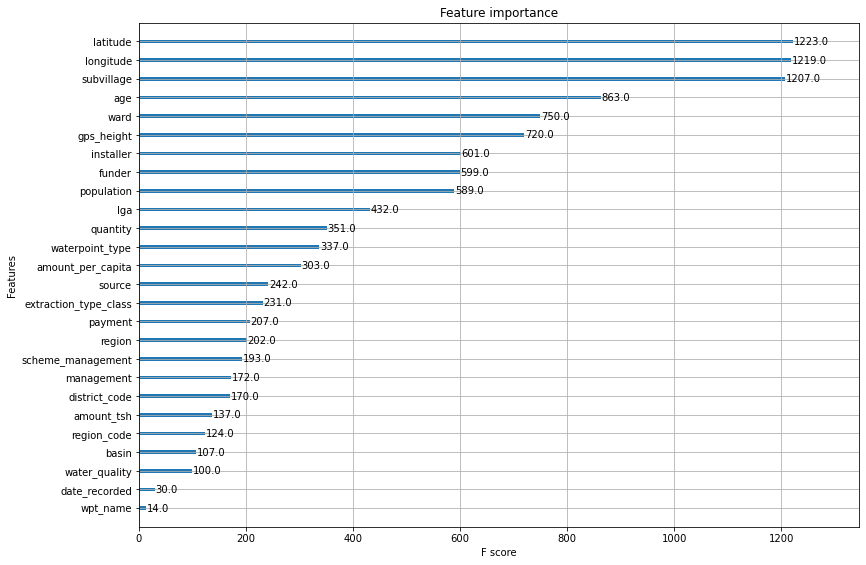

In [108]:
from xgboost import plot_importance

fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
plot_importance(booster=xgb_cf, ax=ax, importance_type="weight")

<BarContainer object of 26 artists>

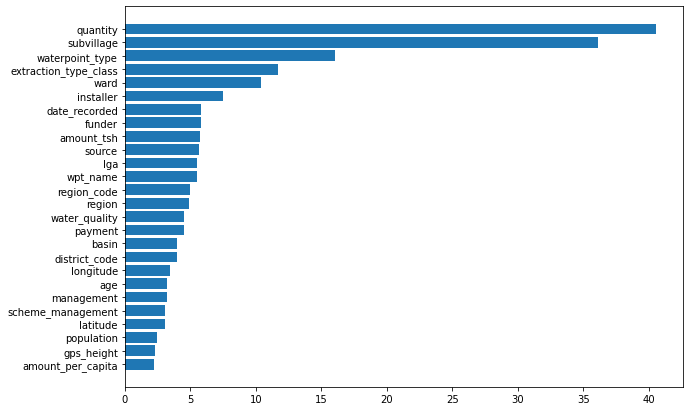

In [109]:
fi_gain = xgb_cf.get_booster().get_score(importance_type='gain')
fi_gain = dict(sorted(fi_gain.items(), key=lambda item: item[1], reverse=False))
names, counts = zip(*fi_gain.items())
plt.figure(figsize=(10, 7))
plt.barh(names, counts)

<BarContainer object of 26 artists>

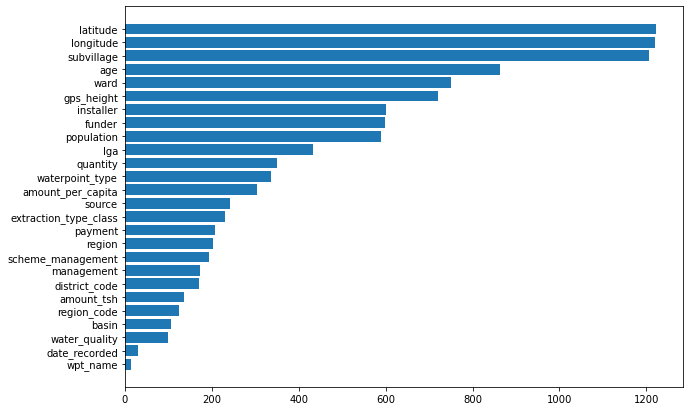

In [110]:
fi_weight = xgb_cf.get_booster().get_score(importance_type='weight')
fi_weight = dict(sorted(fi_weight.items(), key=lambda item: item[1], reverse=False))
names, counts = zip(*fi_weight.items())
plt.figure(figsize=(10, 7))
plt.barh(names, counts)

<BarContainer object of 26 artists>

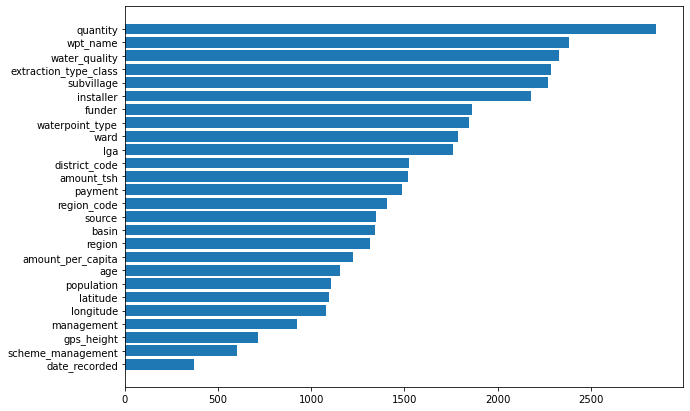

In [111]:
fi_cover = xgb_cf.get_booster().get_score(importance_type='cover')
fi_cover = dict(sorted(fi_cover.items(), key=lambda item: item[1], reverse=False))
names, counts = zip(*fi_cover.items())
plt.figure(figsize=(10, 7))
plt.barh(names, counts)

### Drop Features with low importance

Remove 10 least important features (e.g. least 'gain')

In [125]:
feature_names2 = list(fi_gain.keys())[10:]
feature_names2

['payment',
 'water_quality',
 'region',
 'region_code',
 'wpt_name',
 'lga',
 'source',
 'amount_tsh',
 'funder',
 'date_recorded',
 'installer',
 'ward',
 'extraction_type_class',
 'waterpoint_type',
 'subvillage',
 'quantity']

In [124]:
list(fi_gain.keys())[:10]

['amount_per_capita',
 'gps_height',
 'population',
 'latitude',
 'scheme_management',
 'management',
 'age',
 'longitude',
 'district_code',
 'basin']

In [145]:
col_trans_lbl_reduced = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward']],
    ['ord_enc', ord_enc_pipe, ['payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class', 'region', 'region_code']],
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh"]],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

In [146]:
result_lbl_reduced = col_trans_lbl_reduced.fit_transform(X=df_train, y=y_train)

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anacond

In [147]:
print(result_lbl_reduced.shape)
print(f'({result_lbl_reduced.min()}, {result_lbl_reduced.max()})')

(48958, 16)
(0.0, 1.0)


In [149]:
X_train2 = col_trans_lbl_reduced.fit_transform(X=df_train, y=y_train)

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anacond

In [151]:
xgb_cf2 = XGBClassifier()
xgb_cf2.fit(X_train2, y_train)
y_pred = xgb_cf2.predict_proba(X_train2)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf2, X=X_train2, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [xgb_cf2, auc_train, auc_cv]

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [152]:
df_results

,Model,AUC Train,AUC CV
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.966479,0.926500
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.957016,0.922601


In [153]:
xgb_cf2.get_booster().feature_names = feature_names2

<BarContainer object of 16 artists>

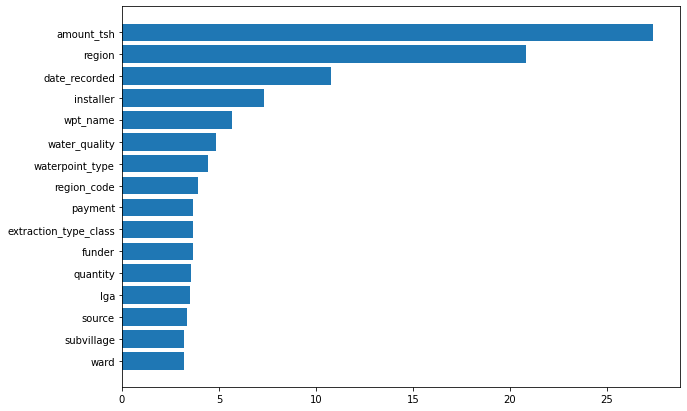

In [154]:
fi_gain = xgb_cf2.get_booster().get_score(importance_type='gain')
fi_gain = dict(sorted(fi_gain.items(), key=lambda item: item[1], reverse=False))
names, counts = zip(*fi_gain.items())
plt.figure(figsize=(10, 7))
plt.barh(names, counts)